## Import Modules

In [92]:
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np
import math
%matplotlib inline

## Read and Clean Data

In [48]:
shots = pd.read_csv('total_shots.csv')

In [49]:
#Analyze shots that have no negative touch time (impossible)
shots=shots[shots['touch_time']>=0]
#Remove shots that are over 40 feet
shots=shots[shots['shot_dist']<40]

#Remove any shot clock observations that are N/A
nan=float('nan')
shots=shots[~np.isnan(shots['shot_clock'])]

#Remove any shots that registered as N/A
nan=float('nan')
shots=shots[~np.isnan(shots['fgm'])]

#Remove any shots that have a closest defender distance over 30
shots=shots[shots['close_def_dist']<30]

#Make fgm values equal 1 if they are initially equal to 2
shots.loc[(shots['fgm'] == 2,'fgm')] = 1

#Create a new feature column called time remaining that combines minutes remaining and seconds remaining
shots['time_remaining'] = (shots['minutes_remaining']) + (shots['seconds_remaining'] * 0.01)

In [50]:
#Read file of teams and their respective team ID
teams = pd.read_csv('team_id.csv')

In [51]:
#Create a dictionary of the team ID csv file
team_dict = dict(zip(teams['TEAM_ID'].values, teams['TEAM_NAME'].values))
team_dict.pop(0,'nan')

nan

In [52]:
team_dict

{1610612737: 'Hawks',
 1610612738: 'Celtics',
 1610612739: 'Cavaliers',
 1610612740: 'Pelicans',
 1610612741: 'Bulls',
 1610612742: 'Mavericks',
 1610612743: 'Nuggets',
 1610612744: 'Warriors',
 1610612745: 'Rockets',
 1610612746: 'Clippers',
 1610612747: 'Lakers',
 1610612748: 'Heat',
 1610612749: 'Bucks',
 1610612750: 'Timberwolves',
 1610612751: 'Nets',
 1610612752: 'Knicks',
 1610612753: 'Magic',
 1610612754: 'Pacers',
 1610612755: '76ers',
 1610612756: 'Suns',
 1610612757: 'Trail Blazers',
 1610612758: 'Kings',
 1610612759: 'Spurs',
 1610612760: 'Thunder',
 1610612761: 'Raptors',
 1610612762: 'Jazz',
 1610612763: 'Grizzlies',
 1610612764: 'Wizards',
 1610612765: 'Pistons',
 1610612766: 'Hornets'}

## EDA: Insights into NBA offensive statistics

In [53]:
pd.set_option('display.max_columns', None)
shots.head()

,Unnamed: 0,closest_defender,closest_defender_player_id,close_def_dist,dribbles,fgm,final_margin,game_clock,game_id,game_id.1,location,matchup,period,period.1,pts,pts_type,shot_clock,shot_dist,shot_number,shot_result,touch_time,w,grid_type,game_event_id,player_id,player_id.1,player_name,team_id,minutes_remaining,seconds_remaining,event_type,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_attempted_flag,shot_made_flag,time_remaining
0,0,"Hudson, Lester",201991.0,2.2,20.0,0.0,-28.0,0:09,21401153,21401153,H,"APR 05, 2015 - LAL vs. LAC",1.0,1.0,0.0,2.0,7.5,18.1,1.0,missed,15.8,L,Shot Chart Detail,105.0,202779.0,202779,Dwight Buycks,1.610613e+09,0.0,7.0,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,16.0,87.0,144.0,1.0,0.0,0.07
1,1,"Rivers, Austin",203085.0,4.1,6.0,0.0,-28.0,7:39,21401153,21401153,H,"APR 05, 2015 - LAL vs. LAC",2.0,2.0,0.0,2.0,14.6,20.8,2.0,missed,8.8,L,Shot Chart Detail,156.0,202779.0,202779,Dwight Buycks,1.610613e+09,7.0,37.0,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,18.0,103.0,151.0,1.0,0.0,7.37
2,2,"Rivers, Austin",203085.0,3.2,7.0,0.0,-28.0,6:10,21401153,21401153,H,"APR 05, 2015 - LAL vs. LAC",4.0,4.0,0.0,2.0,10.9,13.8,3.0,missed,7.4,L,Shot Chart Detail,394.0,202779.0,202779,Dwight Buycks,1.610613e+09,6.0,8.0,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16.0,-108.0,127.0,1.0,0.0,6.08
3,3,"Hudson, Lester",201991.0,8.2,0.0,1.0,-28.0,2:05,21401153,21401153,H,"APR 05, 2015 - LAL vs. LAC",4.0,4.0,3.0,3.0,10.5,22.5,4.0,made,1.1,L,Shot Chart Detail,444.0,202779.0,202779,Dwight Buycks,1.610613e+09,2.0,4.0,Made Shot,Jump Shot,3PT Field Goal,Left Corner 3,Left Side(L),24+ ft.,23.0,-234.0,32.0,1.0,1.0,2.04
4,4,"Hamilton, Jordan",202706.0,4.3,8.0,1.0,-28.0,1:21,21401153,21401153,H,"APR 05, 2015 - LAL vs. LAC",4.0,4.0,3.0,3.0,17.2,24.9,5.0,made,6.5,L,Shot Chart Detail,449.0,202779.0,202779,Dwight Buycks,1.610613e+09,1.0,19.0,Made Shot,Step Back Jump shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,26.0,-193.0,179.0,1.0,1.0,1.19


In [54]:
shots.describe()

,Unnamed: 0,closest_defender_player_id,close_def_dist,dribbles,fgm,final_margin,game_id,game_id.1,period,period.1,pts,pts_type,shot_clock,shot_dist,shot_number,touch_time,game_event_id,player_id,player_id.1,team_id,minutes_remaining,seconds_remaining,shot_distance,loc_x,loc_y,shot_attempted_flag,shot_made_flag,time_remaining
count,379731.000000,379731.000000,379731.000000,379731.000000,379731.000000,379731.000000,3.797310e+05,3.797310e+05,379731.000000,379731.000000,379731.000000,379731.000000,379731.000000,379731.000000,379731.000000,379731.000000,379731.000000,379731.000000,379731.000000,3.797310e+05,379731.000000,379731.000000,379731.000000,379731.000000,379731.000000,379731.0,379731.000000,379731.000000
mean,199585.644709,155686.637127,4.148117,1.938770,0.455994,0.039381,2.135110e+07,2.135110e+07,2.508792,2.508839,1.006352,2.259091,12.488645,13.436214,6.375624,2.672236,254.479105,154737.345510,154737.345510,1.610613e+09,5.474088,29.499641,12.183253,-0.292557,79.202372,1.0,0.456044,5.769085
std,115909.672940,80164.877027,2.670468,3.373105,0.498060,13.633964,4.999470e+04,4.999470e+04,1.144100,1.144111,1.132881,0.438136,5.778995,8.792885,4.673309,2.880986,157.713825,80718.304469,80718.304469,8.683521e+00,3.389683,17.126694,9.597937,109.322482,83.947326,0.0,0.498065,3.383634
min,0.000000,708.000000,0.000000,0.000000,0.000000,-53.000000,2.130000e+07,2.130000e+07,1.000000,1.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,1.000000,708.000000,708.000000,1.610613e+09,0.000000,0.000000,0.000000,-250.000000,-51.000000,1.0,0.000000,0.000000
25%,99139.500000,101150.000000,2.300000,0.000000,0.000000,-9.000000,2.130064e+07,2.130064e+07,1.000000,1.000000,0.000000,2.000000,8.200000,4.700000,3.000000,0.800000,116.000000,101145.000000,101145.000000,1.610613e+09,3.000000,15.000000,2.000000,-54.000000,7.000000,1.0,0.000000,3.020000
50%,198623.000000,201936.000000,3.700000,0.000000,0.000000,1.000000,2.140001e+07,2.140001e+07,2.000000,2.000000,0.000000,2.000000,12.300000,13.300000,5.000000,1.500000,254.000000,201935.000000,201935.000000,1.610613e+09,5.000000,30.000000,12.000000,1.000000,41.000000,1.0,0.000000,5.590000
75%,300060.500000,202713.000000,5.300000,2.000000,1.000000,9.000000,2.140063e+07,2.140063e+07,4.000000,4.000000,2.000000,3.000000,16.700000,22.400000,9.000000,3.600000,387.000000,202702.000000,202702.000000,1.610613e+09,8.000000,44.000000,22.000000,51.000000,151.000000,1.0,1.000000,8.540000
max,401494.000000,530027.000000,29.900000,34.000000,1.000000,53.000000,2.140123e+07,2.140123e+07,7.000000,7.000000,6.000000,3.000000,24.000000,39.900000,43.000000,25.400000,780.000000,204079.000000,204079.000000,1.610613e+09,12.000000,59.000000,62.000000,250.000000,612.000000,1.0,1.000000,12.000000


In [55]:
shots.dtypes

Unnamed: 0                      int64
closest_defender               object
closest_defender_player_id    float64
close_def_dist                float64
dribbles                      float64
fgm                           float64
final_margin                  float64
game_clock                     object
game_id                         int64
game_id.1                       int64
location                       object
matchup                        object
period                        float64
period.1                      float64
pts                           float64
pts_type                      float64
shot_clock                    float64
shot_dist                     float64
shot_number                   float64
shot_result                    object
touch_time                    float64
w                              object
grid_type                      object
game_event_id                 float64
player_id                     float64
player_id.1                     int64
player_name 

In [56]:
#Create a dictionary of teams and player:player_id
teams ={'wizards':{
                   'garrett temple':202066,
                   'andre miller':1889,
                   'kevin seraphin':202338,
                   'otto porter':203490,
                   'rasual butler':2446,
                   'kris humphries':2743,
                   'nene hilario':2403,
                   'paul pierce':1718,
                   'marcin gortat':101162,
                   'bradley beal':203078,
                   'john wall':202322},
        'magic'  :{
                   'ben gordon':2732,
                   'aaron gordon':203932,
                   'kyle oquinn':203124,
                   'channing frye':101112,
                   'elfrid payton':203901,
                   'evan fournier':203095,
                   'victor oladipo':203506,
                   'nikola vucevic':202696,
                   'tobias harris':202699},
        'heat'    :{
                    'mario chalmers':201596,
                    'dwayne wade':2548,
                    'udonis haslem':2617,
                    'chris andersen': 2365,
                    'shabazz napier':203894,
                    'james ennis':203516,
                    'chris bosh':2547,
                    'shawne williams':200761,
                    'luol deng':2736,
                    'norris cole':202708},
        'hornets'  :{
                    'brian roberts':203148,
                    'michael kidd-gilchrist':203077,
                    'jason maxiell':101131,
                    'bismack biyombo':202687,
                    'lance stephenson':202362,
                    'kemba walker':202689,
                    'gary neal':202390,
                    'al jefferson':2744,
                    'marvin williams':101107,
                    'gerald henderson':201945,
                    'cody zeller':203469},
        'hawks'    :{'pero antic':203544,
                     'thabo sefolosha':200757,
                     'demarre carroll':201960,
                     'kent bazemore':203145,
                     'jeff teague':201952,
                     'al horford':201143,
                     'mike scott':203118,
                     'dennis schroder':203471,
                     'kyle korver':2594,
                     'paul millsap':200794},
        'bucks'     :{'john henson':203089,
                      'zaza pachulia':2585,
                      'khris middleton':203114,
                      'jerryd bayless':201573,
                      'brandon knight':202688,
                      'oj mayo':201564,
                      'jared dudley':201162,
                      'giannis antetokounmpo':203507},
        'pacers'    :{'cj watson':201228,
                      'david west':2561,
                      'donald sloan':202388,
                      'lavoy allen':202730,
                      'damjan rudez':204014,
                      'chris copeland':203142,
                      'cj miles':101139,
                      'rodney stuckey':201155,
                      'roy hibbert':201579,
                      'luis scola':2449,
                      'solomon hill':203524},
        'pistons'    :{'brandon jennings':201943,
                       'jonas jerebko':201973,
                       'caron butler':2406,
                       'greg monroe':202328,
                       'kyle singler':202713,
                       'kentavious caldwell-pope':203484,
                       'dj augustin':201571,
                       'andre drummond':203083},
        'cavaliers'   :{'mike miller':2034,
                        'joe harris':203925,
                        'matthew dellavedova':203521,
                        'lebron james':2544,
                        'shawn marion':1890,
                        'kevin love':201567,
                        'kyrie irving':202681,
                        'tristan thompson':202684},
        'bulls'       :{'joakim noah':201149,
                        'derrick rose':201565,
                        'kirk hinrich':2550,
                        'tony snell':203503,
                        'taj gibson':201959,
                        'jimmy butler':202710,
                        'pau gasol':2200,
                        'nikola mirotic':202703,
                        'aaron brooks':201166},
        'raptors'     :{'james johnson':201949,
                        'tyler hansbrough':201946,
                        'amir johnson':101161,
                        'jonas valanciunas':202685,
                        'kyle lowry':200768,
                        'lou williams':101150,
                        'greivis vasquez':202349,
                        'patrick patterson':202335,
                        'terrence ross':203082},
        'sixers'       :{'jerami grant':203924,
                         'michael carter-williams':203487,
                         'hollis thompson':203138,
                         'robert covington':203496,
                         'luc mbah a moute':201601,
                         'jakarr sampson':203960,
                         'nerles noel':203457,
                         'kj mcdaniels':203909,
                         'henry sims':203156},
        'knicks'        :{'cole aldrich':202332,
                          'amare stoudemire':2405,
                          'travis wear':204037,
                          'jose calderon':101181,
                          'carmelo anthony':2546,
                          'pablo prigioni':203143,
                          'quincy acy':203112,
                          'shane larkin':203499,
                          'tim hardaway jr':203501,
                          'jason smith':201160},
        'nets'           :{'jerome jordan':202366,
                           'deron williams':101114,
                           'mirza teletovic':203141,
                           'brook lopez':201572,
                           'kevin garnett':708,
                           'joe johnson':2207,
                           'bojan bogdanovic':202711,
                           'alan anderson':101187,
                           'mason plumlee':203486,
                           'jarrett jack':101127},
        'celtics'       :{'jeff green':201145,
                          'marcus smart':203935,
                          'marcus thornton':201977,
                          'kelly olynyk':203482,
                          'avery bradley':202340,
                          'tyler zeller':203092,
                          'evan turner':202323,
                          'brandon bass':101138,
                          'jared sullinger':203096},
        'spurs'          :{'marco belinelli':201158,
                           'kawhi leonard':202695,
                           'tony parker':2225,
                           'manu ginobili':1938,
                           'matt bonner':2588,
                           'aron baynes':203382,
                           'tim duncan':1495,
                           'cory joseph':202709,
                           'danny green':201980,
                           'boris diaw':2564},
        'pelicans'        :{'dante cunningham':201967,
                            'jrue holiday':201950,
                            'jimmer dredette':202690,
                            'alexis ajinca':201582,
                            'luke babbitt':202337,
                            'anthony davis':203076,
                            'omer asik':201600,
                            'ryan anderson':201583,
                            'tyreke evans':201936},
        'grizzlies'        :{'vince carter':1713,
                             'zach randolph':2216,
                             'tony allen':2754,
                             'jon leuer':202720,
                             'mike conley':201144,
                             'courtney lee':201584,
                             'beno urdih':2757,
                             'kosta koufos':201585,
                             'marc gasol':201188},
        'rockets'           :{'dwight howard':2730,
                              'kostas papanikolaou':203123,
                              'patrick beverley':201976,
                              'joey dorsey':201595,
                              'jason terry':1891,
                              'donatas motiejunas':202700,
                              'trevor ariza':2772,
                              'james harden':201935},
        'mavericks'          :{'greg smith':202962,
                               'charlie villanueva':101111,
                               'al farouq aminu':202329,
                               'richard jefferson':2210,
                               'dirk nowtizski':1717,
                               'chandler parsons':202718,
                               'tyson chandler':2199,
                               'devin harris':2734,
                               'jose juan barea':200826,
                               'mnta ellis':101145},
        'kings'               :{'ramon sessions':201196,
                                'omri casspi':201956,
                                'ray mccallum':203492,
                                'demarcus cousins':202326,
                                'derrick williams':202682,
                                'darren collison':201954,
                                'carl landry':201171,
                                'rudy gay':200752,
                                'nik stauskas':203917,
                                'jason thompson':201574,
                                'ben mclemore':203463},
        'suns'                 :{'isaiah thomas':202738,
                                 'pj tucker':200782,
                                 'alex len':203458,
                                 'goran dragic':201609,
                                 'gerald green':101123,
                                 'eric bledsoe':202339,
                                 'markieff morris':202693,
                                 'marcus morris':202694},
        'lakers'                :{'kobe bryant':977,
                                  'nick young':201156,
                                  'ronnie price':101179,
                                  'wayne ellington':201961,
                                  'robert sacre':203135,
                                  'jordan hill':201941,
                                  'wesley johnson':202325,
                                  'carlos boozer':2430,
                                  'jeremy lin':202391,
                                  'ed davis':202334},
        'clippers'               :{'hedo turkoglu':2045,
                                   'jordan farmar':200770,
                                   'spencer hawes':201150,
                                   'glen davis':201175,
                                   'jj redick':200755,
                                   'blake griffin':201933,
                                   'matt barnes':2440,
                                   'jamal crawford':2037,
                                   'deandre jordan':201599,
                                   'chris paul':101108},
        'warriors'               :{'andrew bogut':101106,
                                   'leandro barbosa':2571,
                                   'marreese speights':201578,
                                   'shaun livingston':2733,
                                   'andre iguodala':2738,
                                   'klay thompson':202691,
                                   'draymond green':203110,
                                   'harrison barnes':203084,
                                   'stephen curry':201939},
        'jazz'                    :{'enes kanter':202683,
                                    'derrick favors':202324,
                                    'jon ingles':204060,
                                    'trevor booker':202344,
                                    'trey burke':203504,
                                    'rudy gobert':203497,
                                    'gordon hayward':202330,
                                    'dante exum':203957},
        'blazers'                  :{'alan crabbe':203459,
                                     'cj mccollum':203468,
                                     'nicolas batum':201587,
                                     'lamarcus aldridge':200746,
                                     'chris kaman':2549,
                                     'wesley matthews':202083,
                                     'steve blake':2581,
                                     'damian lillard':203081},
        'thunder'                   :{'jeremy lamb':203087,
                                      'russell westbrook':201566,
                                      'andre roberson':203460,
                                      'anthony morrow':201627,
                                      'kevin durant':201142,
                                      'nick collison':2555,
                                      'reggie jackson':202704,
                                      'steve adams':203500,
                                      'kendrick perkins':2570,
                                      'serge ibaka':201586},
        'timberwolves'               :{'robbie hummel':203133,
                                       'shabazz muhammad':203498,
                                       'mo williams':2590,
                                       'chase budinger':201978,
                                       'thaddeus young':201152,
                                       'zach lavine':203897,
                                       'anthony bennett':203461,
                                       'gorgui dieng':203476,
                                       'andrew wiggins':203952},
        'nuggets'                     :{'arron afflalo':201167,
                                        'danilo gallinai':201568,
                                        'timofey mozgov':202389,
                                        'nate robinson':101126,
                                        'alonzo gee':202087,
                                        'jusuf nurkic':203994,
                                        'darrell arthur':201589,
                                        'kenneth faried':202702,
                                        'ty lawson':201951,
                                        'wilson chandler':201163,
                                        'jj hickson':201581}}
#source: http://www.danielforsyth.me/exploring_nba_data_in_python/

In [57]:
players = []
player_stats = {'name':None,'avg_dribbles':None,'avg_touch_time':None,'avg_shot_distance':None,'avg_def_distance':None,'spacing':None, 'avg_fg':None,'avg_3fg':None,'total_shots':None,'efg':None}

In [58]:
def find_stats(name,player_id):  
    """Appends to a dictionary of statistics for each NBA player

    This function displays the average field goal points, 
    average defender distance, average shot distance, fgm, fga, fg%,
    3 point fg%, mid-range fg%, paint fg%, and effective fg%.

    Parameters
    ----------
    player_id : Player ID, required
        Player ID needed to grab the respective shot log
    name : Name, required
        Player Name needed to create a new column
        
    Appends
    -------
    player : list of statistics
        The associated statistics for each team

    """
    #Create a df for a specific player
    df = shots[(shots.player_id == player_id)]
    avg_def = df['close_def_dist'].mean()
    avg_dribbles = df['dribbles'].mean()
    avg_shot_distance = df['shot_dist'].mean()
    avg_touch_time = df['touch_time'].mean()
    spacing = sum(df['shot_dist'])/sum(df['close_def_dist'])
    fgm = sum(df['shot_made_flag'] == 1)
    fga = sum(df['shot_attempted_flag'] == 1)
    avg_fg = sum(df.shot_made_flag == 1)/sum(df.shot_attempted_flag == 1)
    avg_3fg = (len(df[(df.shot_made_flag == 1) & (df.shot_type == '3PT Field Goal')])+.00001)/(float(len(df[(df.shot_attempted_flag == 1) & (df.shot_type == '3PT Field Goal')]))+ .00001)
    total_shots = sum(df.shot_attempted_flag == 1)
    efg = ((fgm) + (0.5* ((len(df[(df.shot_made_flag == 1) & (df.shot_zone_basic == 'Left Corner 3')]))+(len(df[(df.shot_made_flag == 1) & (df.shot_zone_basic == 'Right Corner 3')]))+ (len(df[(df.shot_made_flag == 1) & (df.shot_zone_basic == 'Above the Break 3')])))))/(fga)
    #add player averages to dictionary 
    player_stats['name'] = name
    player_stats['avg_def_distance']=avg_def
    player_stats['avg_shot_distance'] = avg_shot_distance
    player_stats['avg_touch_time'] = avg_touch_time
    player_stats['avg_dribbles'] = avg_dribbles
    player_stats['avg_fg'] = avg_fg
    player_stats['spacing'] = spacing
    player_stats['total_shots'] = total_shots
    player_stats['avg_3fg'] = avg_3fg
    player_stats['efg'] = efg
    players.append(player_stats.copy())

In [59]:
#Iterate through the dictionary of team names and use the find stats function
for x in teams:
    for y in teams[x]:
        find_stats(y,teams[x][y])
#Creating a new dataframe based on the find_stats function        
cols = ['name','avg_def_distance','avg_dribbles','avg_shot_distance','avg_touch_time','spacing','avg_fg','avg_3fg','total_shots','efg']  
df = pd.DataFrame(players,columns = cols)
df = df.round(3)

In [60]:
df.loc[df['avg_3fg'] == 1,'avg_3fg'] = 0.0

In [61]:
#Ranking the NBA players with over 1000 shots by Effective FG percentage 
df = df[df.total_shots>1000]
df.sort_values('efg', ascending=False).head()

,name,avg_def_distance,avg_dribbles,avg_shot_distance,avg_touch_time,spacing,avg_fg,avg_3fg,total_shots,efg
0,kyle korver,5.017,0.358,21.625,1.117,4.311,0.480,0.483,1127,0.649
238,dwight howard,2.480,1.001,4.400,2.328,1.774,0.598,0.750,1157,0.599
195,stephen curry,4.506,4.500,17.949,4.597,3.984,0.484,0.444,2533,0.586
149,lebron james,4.111,4.120,13.106,5.073,3.188,0.536,0.384,2403,0.582
120,amir johnson,3.308,0.411,7.970,1.304,2.409,0.562,0.350,1051,0.579


In [62]:
#Looking at the league average field goal percentage of each shot zone 
shots['fgm'].groupby(shots['shot_zone_basic']).mean()

shot_zone_basic
Above the Break 3        0.353961
Backcourt                0.000000
In The Paint (Non-RA)    0.395544
Left Corner 3            0.387397
Mid-Range                0.397759
Restricted Area          0.607314
Right Corner 3           0.392317
Name: fgm, dtype: float64

In [63]:
#Looking at the Warrior's field goal percentage of each shot zone
warriors = shots[shots.team_id == 1610612744]
warriors['fgm'].groupby(warriors['shot_zone_basic']).mean()

shot_zone_basic
Above the Break 3        0.386989
In The Paint (Non-RA)    0.398605
Left Corner 3            0.416830
Mid-Range                0.408086
Restricted Area          0.638079
Right Corner 3           0.454148
Name: fgm, dtype: float64

//anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
//anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:898: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


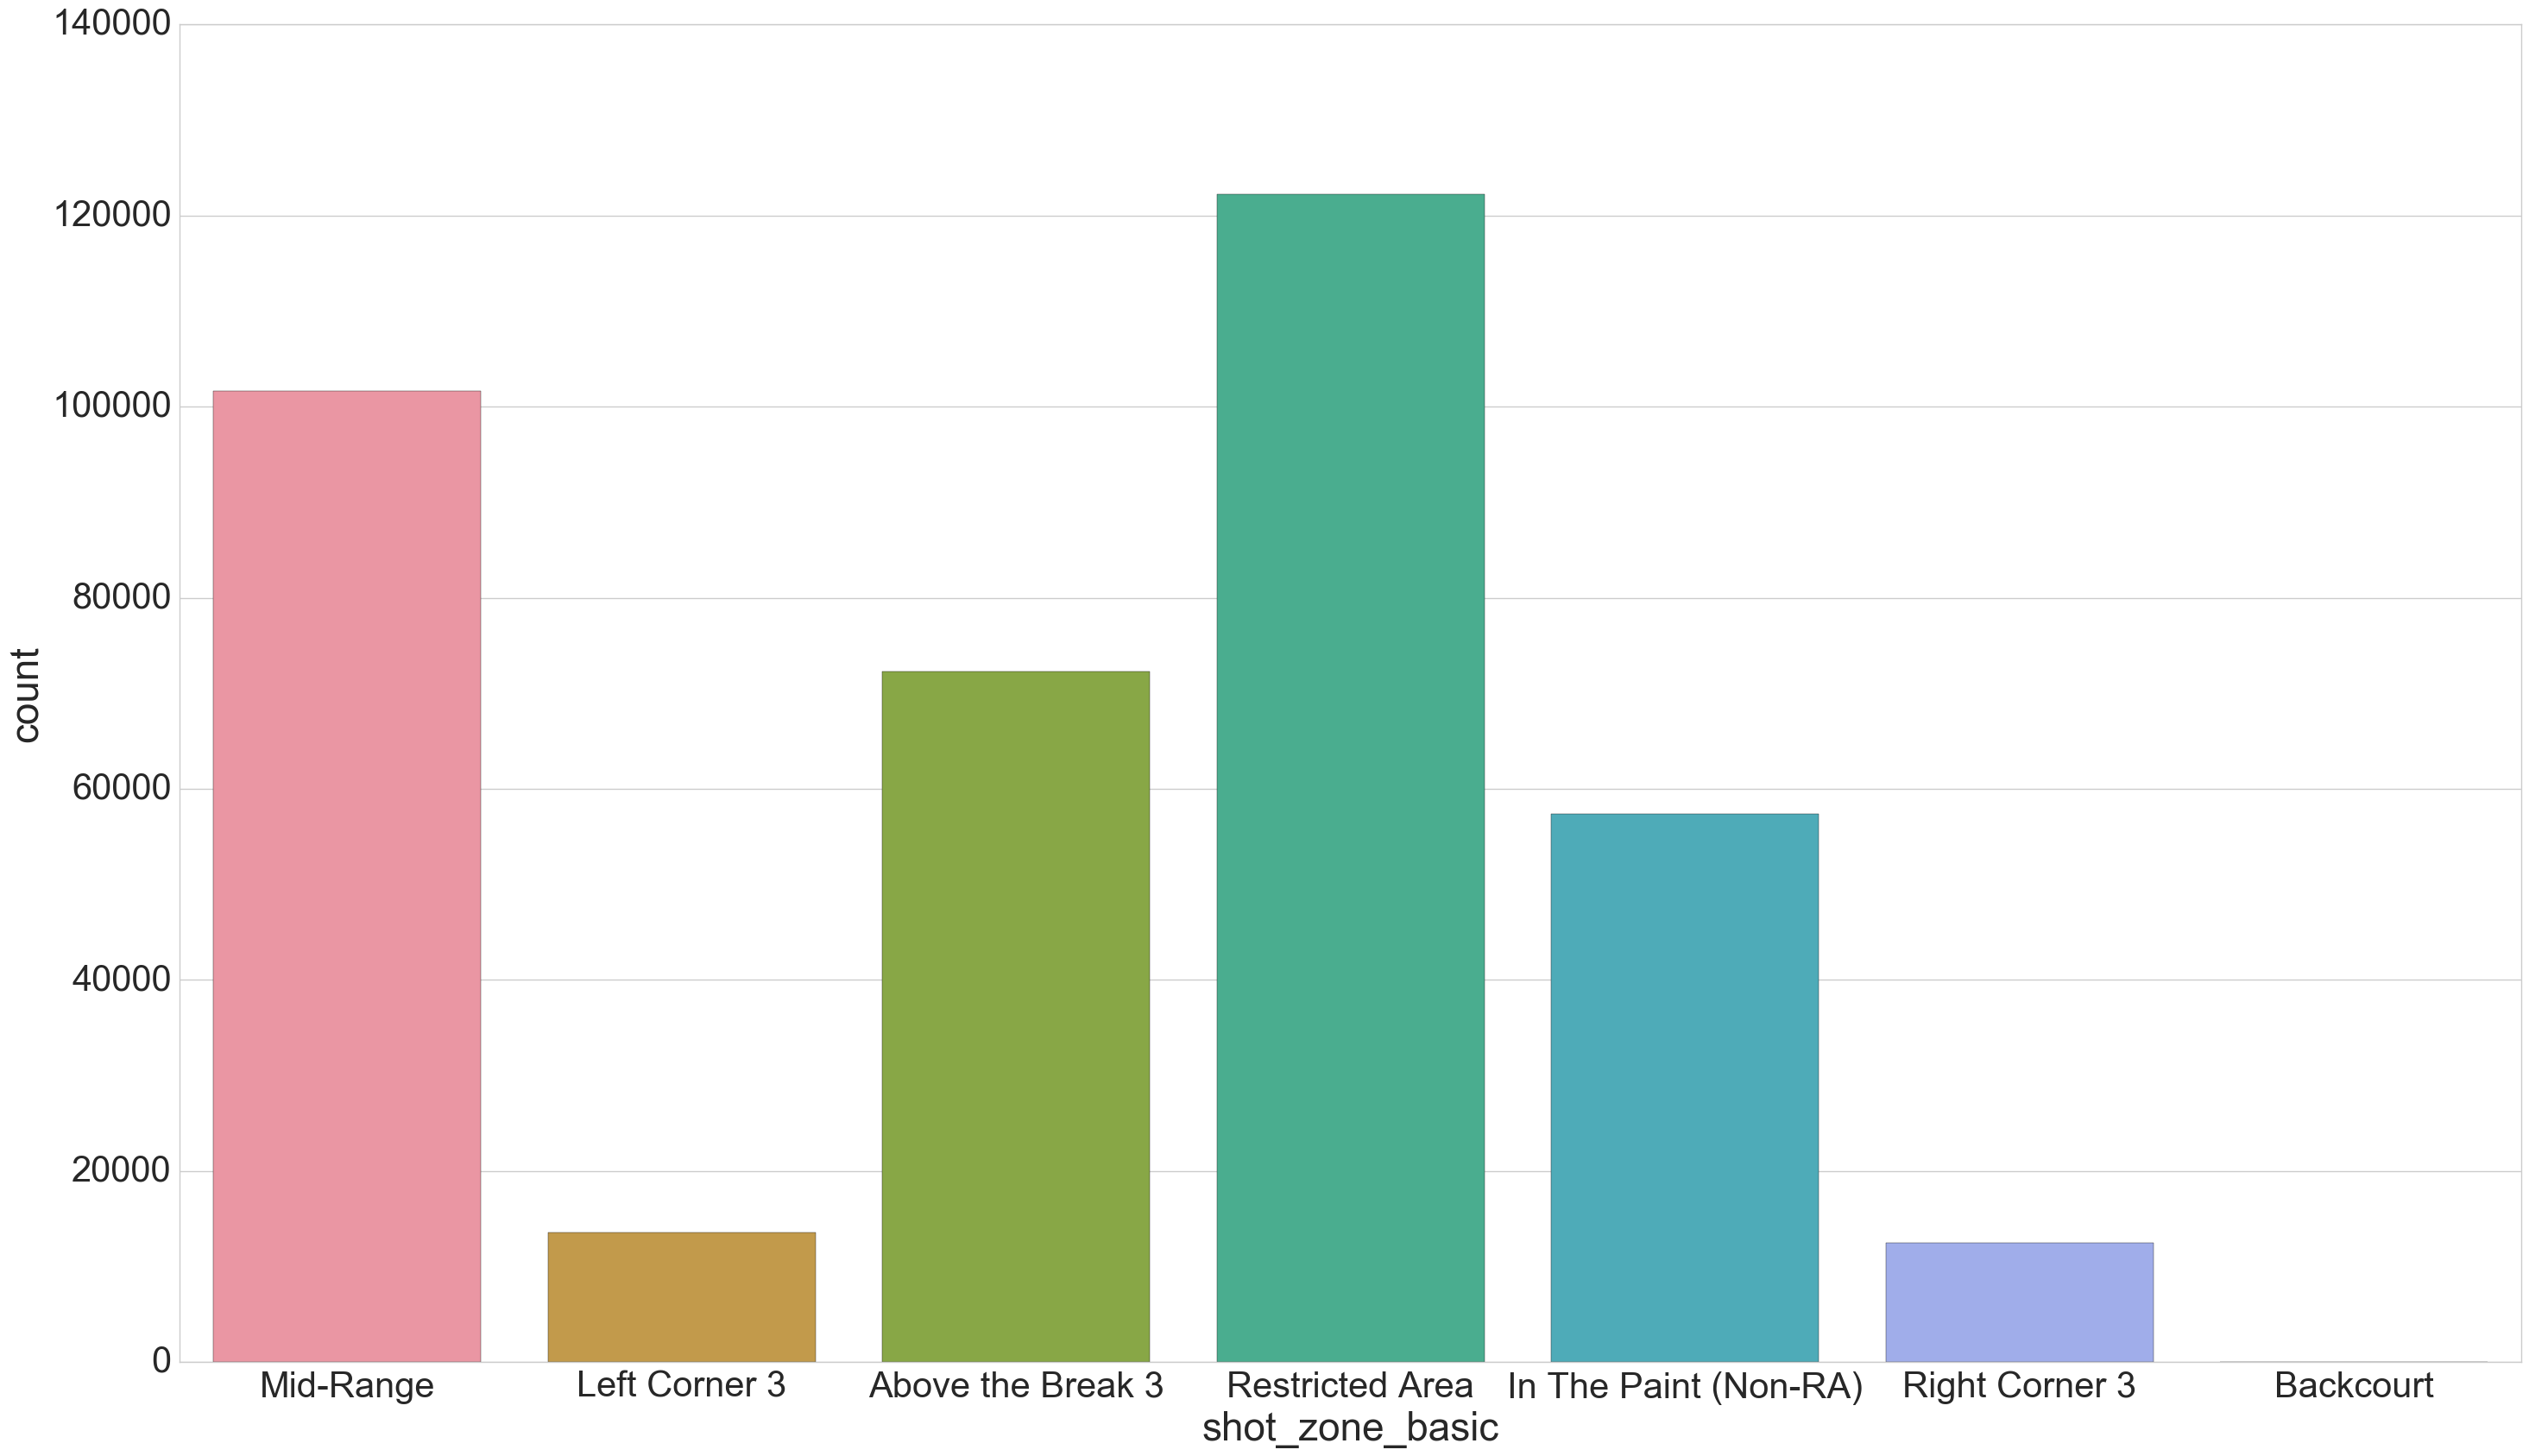

In [64]:
sns.set(style="whitegrid", color_codes=True, font_scale = 3)
plt.figure(figsize=(35,20))
sns.countplot(x="shot_zone_basic", data=shots);

In [65]:
def team_offense(team_id,team_name):
    """Creates a count bar plot of a team's respective shot zone distribution.

    This function graphs the count of mid-range jump shots,
    left corner 3's, right corner 3's, above the break 3's,
    in the paint(non-RA), and restricted area shots.

    Parameters
    ----------
    team_id : Team ID, required
        The Team ID needed to grab the respective shot log
    team_name : Team Name, required
        The Team Name needed to create a new column that used Team Name instead of the Team ID
        
    Plots
    -------
    countplot : plot of shot zone distribution
        The associated shot zone bar chart for a respective NBA team.

    """    
    
    df = shots[(shots.team_id == team_id)]
    sns.set(style="whitegrid", color_codes=True, font_scale = 3)
    plt.figure(figsize=(35,20))
    sns.countplot(x="shot_zone_basic", data=df);

//anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
//anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:898: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


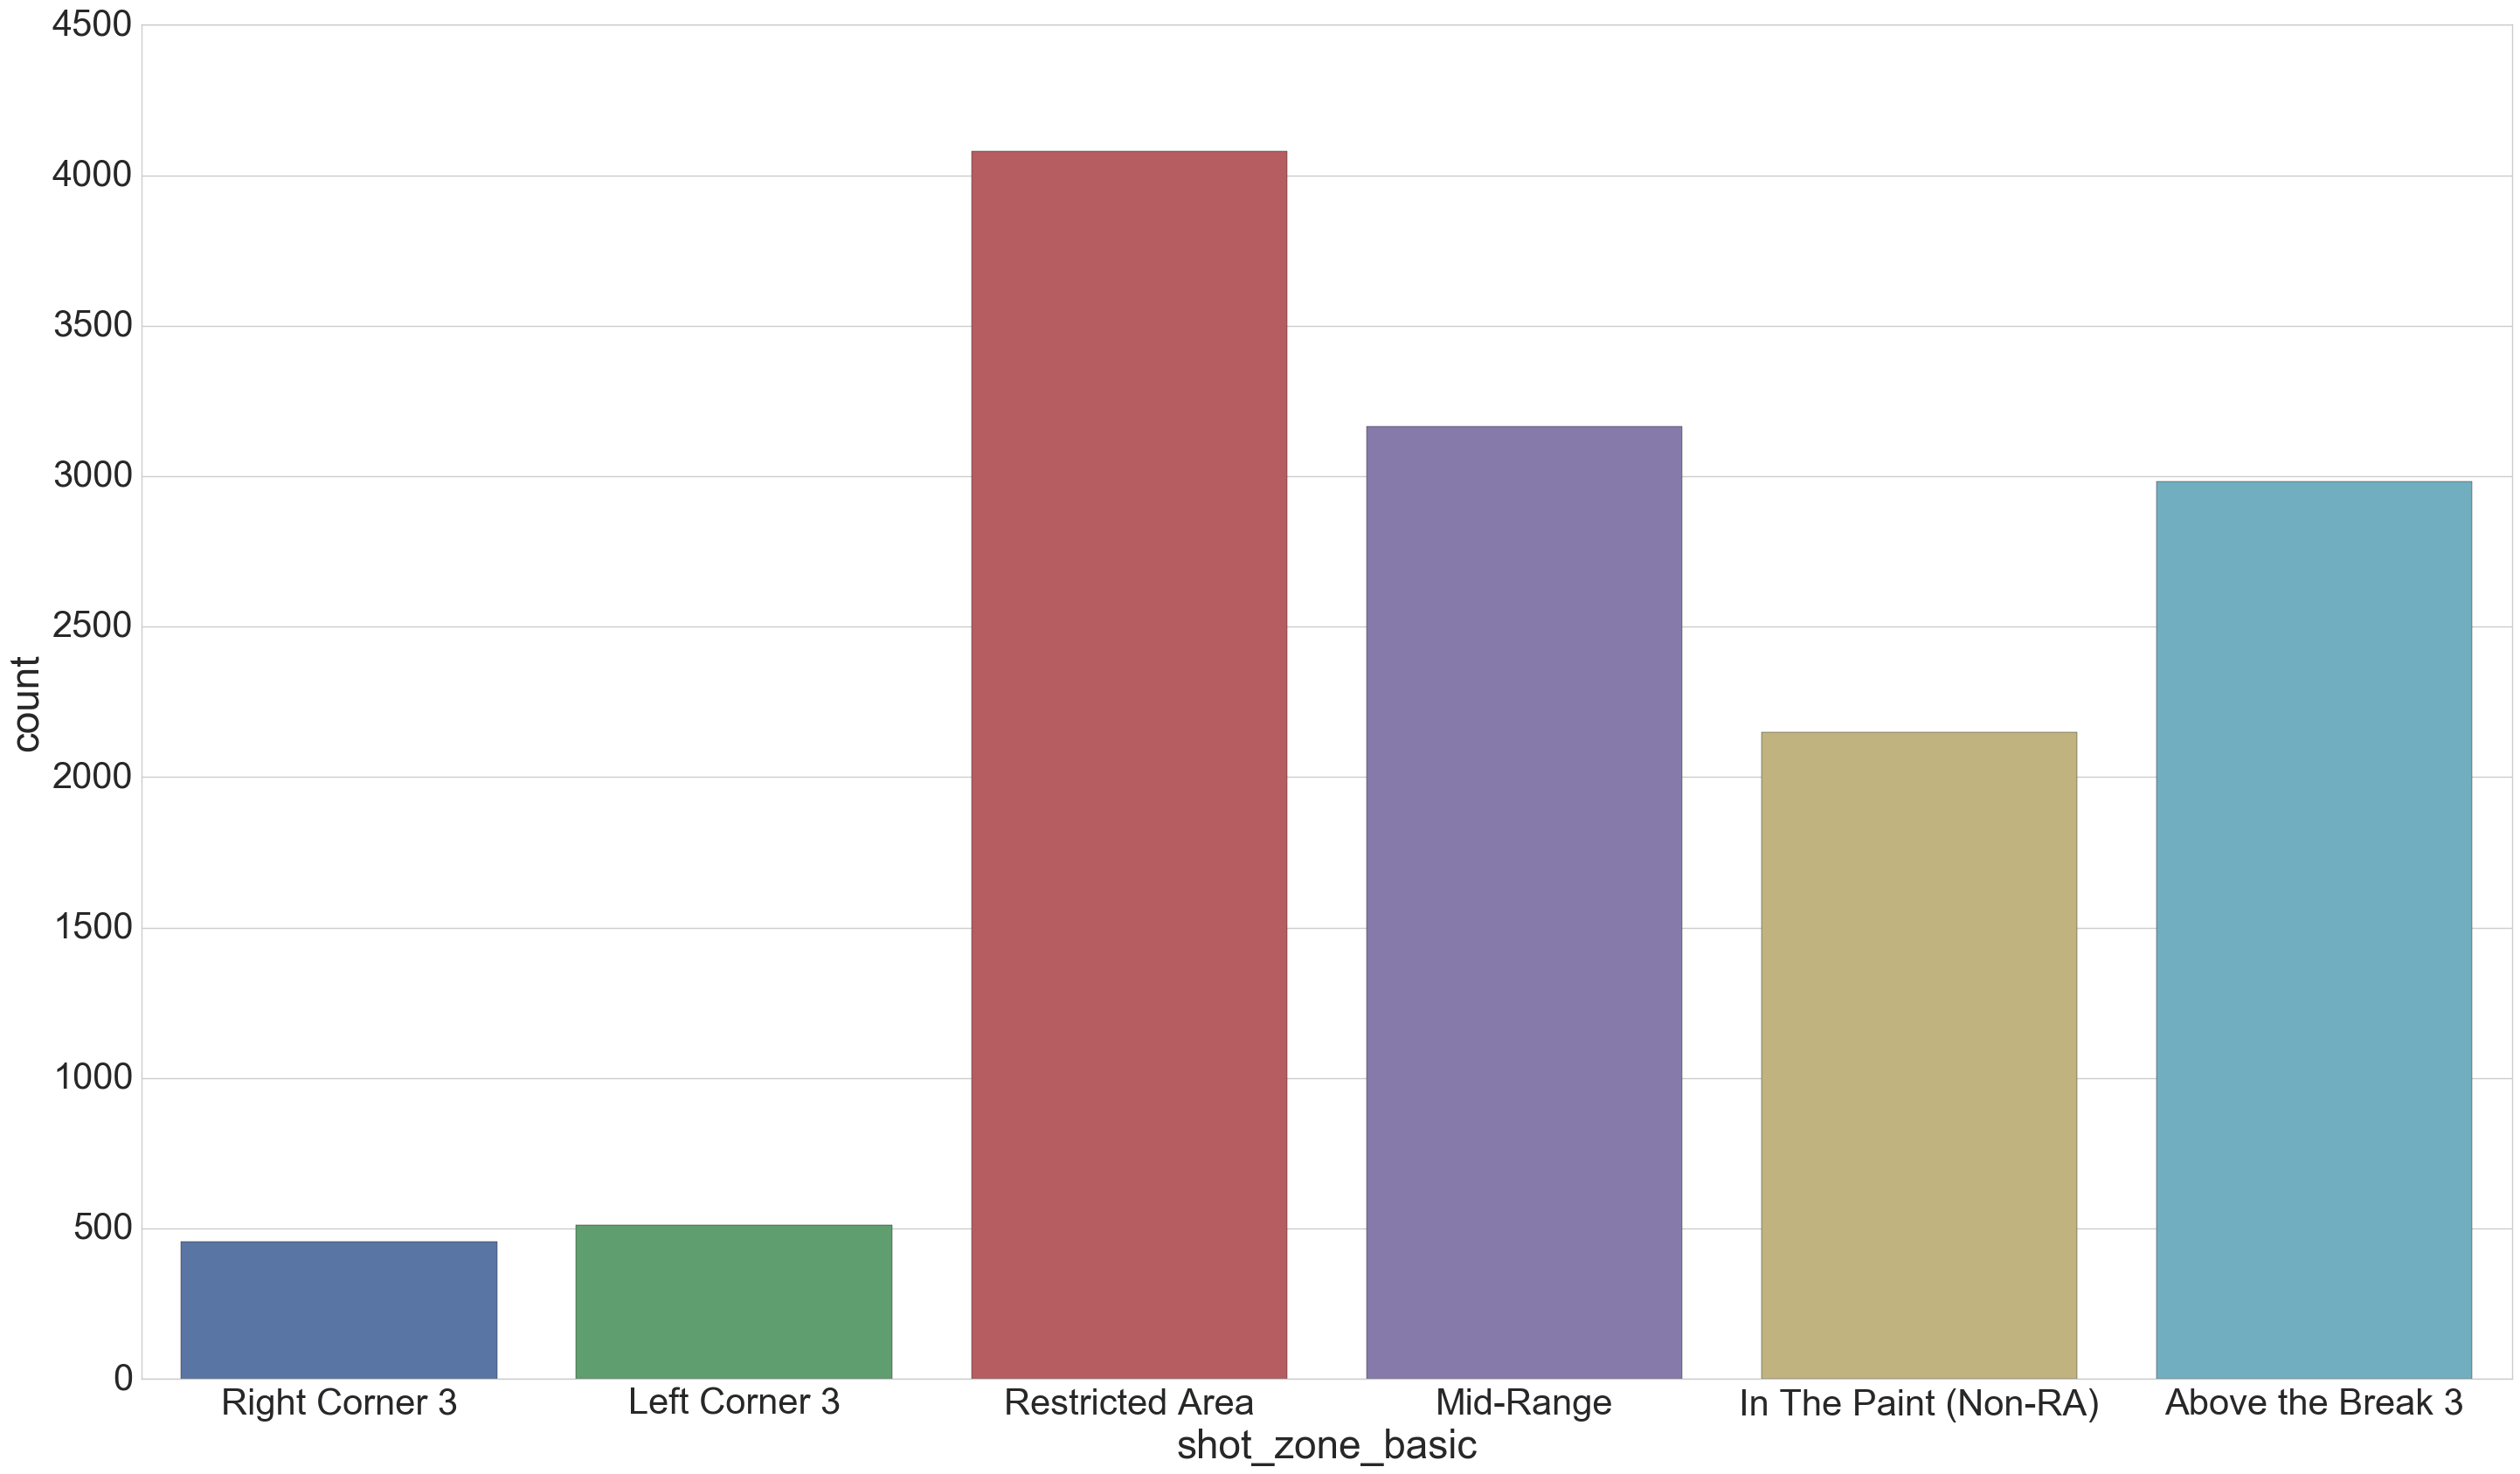

In [66]:
team_offense(1610612744, 'Warriors')

### Import Packages for Plotting

In [67]:
from bokeh.plotting import output_notebook, show
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool
import numpy as np
import bokeh.plotting
output_notebook()

Loading BokehJS ...

In [68]:
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool


def scatter_with_hover(df, x, y,
                       fig=None, cols=None, name=None, marker='square',
                       fig_width=600, fig_height=600, **kwargs):

    # If we haven't been given a Figure obj then create it with default
    # size etc.
    if fig is None:
        fig = figure(width=fig_width, height=fig_height, tools=['box_zoom', 'reset'])

    # We're getting data from the given dataframe
    source = ColumnDataSource(data=df)

    # We need a name so that we can restrict hover tools to just this
    # particular 'series' on the plot. You can specify it (in case it
    # needs to be something specific for other reasons), otherwise
    # we just use 'main'
    if name is None:
        name = 'main'

    # Actually do the scatter plot - the easy bit
    # (other keyword arguments will be passed to this function)
    fig.scatter(df[x], df[y], source=source, name=name, marker=marker, **kwargs)

    # Now we create the hover tool, and make sure it is only active with
    # the series we plotted in the previous line
    hover = HoverTool(names=[name])

    if cols is None:
        # Display *all* columns in the tooltips
        hover.tooltips = [(c, '@' + c) for c in df.columns]
    else:
        # Display just the given columns in the tooltips
        hover.tooltips = [(c, '@' + c) for c in cols]

    # Finally add/enable the tool
    fig.add_tools(hover)

    return fig

In [69]:
fig = scatter_with_hover(df,x="total_shots", y="efg");
show(fig)

### Calculating Shot Probabilities

In [70]:
test12 = shots[(shots['pts_type']== 3)]

In [71]:
test12.close_def_dist.describe()

count    98385.000000
mean         6.121437
std          2.911682
min          0.000000
25%          4.300000
50%          5.500000
75%          7.000000
max         28.000000
Name: close_def_dist, dtype: float64

In [72]:
ta = test12[(test12['close_def_dist']>=7)]
ta = sum(ta['shot_made_flag'] == 1)/sum(ta['shot_attempted_flag'] == 1)
ta

0.40265659083826738

#### What is the probability that Stephen Curry makes a wide open 3 pointer? (closest defender distance is more than 8 feet away)

In [73]:
sc = shots[(shots['player_id']== 201939)& (shots['pts_type']== 3)]

In [74]:
sc.close_def_dist.describe()

count    1160.000000
mean        5.435431
std         2.657679
min         0.200000
25%         3.800000
50%         5.000000
75%         6.400000
max        21.800000
Name: close_def_dist, dtype: float64

In [75]:
sc_open = sc[(sc['close_def_dist']>=7)]
sc_openfg = sum(sc_open['shot_made_flag'] == 1)/sum(sc_open['shot_attempted_flag'] == 1)

In [76]:
"{:.2f}%".format(sc_openfg*100)

'48.10%'

#### What is the probability that Stephen Curry makes a contested 3 pointer? (closest defender is less than 3.8 feet away)

In [77]:
sc_tc = sc[(sc['close_def_dist']<3.8)]

In [78]:
sc_tcfg = sum(sc_tc['shot_made_flag'] == 1)/sum(sc_tc['shot_attempted_flag'] == 1)
"{:.2f}%".format(sc_tcfg*100)

'38.79%'

#### What is the probability that someone misses a dunk?

In [79]:
dunk_prob = shots[(shots['action_type'].str.contains('Dunk'))]
dunkfg= sum(dunk_prob['shot_made_flag'] == 1)/sum(dunk_prob['shot_attempted_flag'] == 1)

In [80]:
"{:.2f}%".format(dunkfg*100)

'91.35%'

In [81]:
miss_dunk = 1 - dunkfg
"{:.2f}%".format(miss_dunk*100)

'8.65%'

#### Based of the previous question, is a dunk more of a high percentage shot than a layup?

In [82]:
layup_prob = shots[(shots['action_type'].str.contains('Layup'))]
layup_fg = sum(layup_prob['shot_made_flag'] == 1)/sum(layup_prob['shot_attempted_flag'] == 1)

In [83]:
"{:.2f}%".format(layup_fg*100)

'58.33%'

### Hypothesis Testing
#### State Null and Alternative Hypothesis

In [84]:
df.sort_values('avg_3fg', ascending=False).head()

,name,avg_def_distance,avg_dribbles,avg_shot_distance,avg_touch_time,spacing,avg_fg,avg_3fg,total_shots,efg
238,dwight howard,2.480,1.001,4.400,2.328,1.774,0.598,0.750,1157,0.599
0,kyle korver,5.017,0.358,21.625,1.117,4.311,0.480,0.483,1127,0.649
257,anthony morrow,4.524,0.878,17.658,1.521,3.903,0.465,0.444,1073,0.567
195,stephen curry,4.506,4.500,17.949,4.597,3.984,0.484,0.444,2533,0.586
209,jose calderon,4.626,2.500,20.334,2.823,4.396,0.443,0.441,1061,0.557


Almost everyone who watches the NBA says that Stephen Curry is the best 3-point shooter in the world. Based on the 2013-2014 and 2014-2015 NBA seasons, I claim that Kyle Korver is a better 3 point shooter than Stephen Curry.

$H_o= p_{1} \geq p_{2}$,
$H_a= p_{1} < p_{2} $

$p_1$ = Stephen Curry's 3 point field goal percentage

$p_2$ = Kyle Korver's 3 point field goal percentage

#### Set alpha level

$\alpha = 0.05$

#### Calculate test statistic

In [85]:
sc3 = shots[(shots['player_id']== 201939)& (shots['pts_type']== 3)]
n_sc = len(sc3)
n_sc

1160

In [86]:
scm = shots.loc[(shots['player_id']== 201939)& (shots['pts_type']== 3) & (shots['shot_made_flag']== 1)]
p_sc = len(scm)
p_sc

515

In [87]:
kk3 =shots[(shots['player_id']== 2594)& (shots['pts_type']== 3)]
n_kk = len(kk3)
n_kk

786

In [88]:
kkm = shots[(shots['player_id']== 2594)& (shots['pts_type']== 3) & (shots['shot_made_flag']== 1)]
p_kk = len(kkm)
p_kk

380

Using the z-score formula for two proportions:

$z = \frac{p_{1}^\hat{}-p_{2}^\hat{}}{\sqrt{p^\hat{}(1-p^\hat{})}\sqrt{\frac{1}{n_{1}}+{\frac{1}{n_{2}}}}}$

In [89]:
p1 = 515/1160
p2 = 380/786
p = (515+380)/(1160+786)

In [90]:
z = (p1-p2)/((math.sqrt(p*(1-p)))*((math.sqrt((1/n_sc)+(1/n_kk)))))
z

-1.71530516776335

In [94]:
p_value = stats.norm.sf(abs(z))
'{:.3f}'.format(p_value)

'0.043'

#### Construct Acceptance/Rejection Regions

P-value of $0.043$ is less than the $\alpha = 0.05$

#### Conclusion

We reject the null hypothesis. There is sufficient evidence to suggest that Stephen Curry is not a better 3 point shooter than Kyle Korver.

#### Acknowledgements
Posts by Daniel Forsyth (http://www.danielforsyth.me/exploring_nba_data_in_python/) about exploring NBA shot logs and Robin Wilson (http://blog.rtwilson.com/bokeh-plots-with-dataframe-based-tooltips/) on plotting interactive Bokeh data visualizations served as very useful resources.